In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [18]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    # "scb10x/typhoon2-qwen2vl-7b-vision-instruct",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

ModuleNotFoundError: No module named 'unsloth'

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled dataset of handwritten maths formulas. The goal is to convert these images into a computer readable form - ie in LaTeX form, so we can render it. This can be very useful for complex formulas.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [19]:
from datasets import load_dataset

dataset = load_dataset("Tuch/food_and_travel", split = "train")
dataset = dataset.select(range(0, 1000))
dataset


Dataset({
    features: ['image', 'caption'],
    num_rows: 1000
})

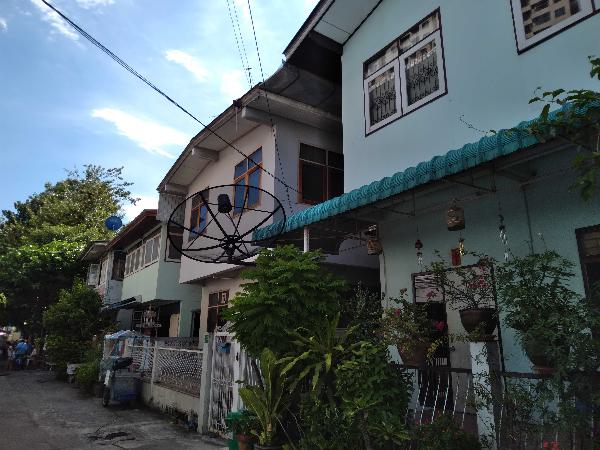

In [23]:
dataset[0]["image"]

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [22]:
dataset[0]["caption"]

'อาคารสีฟ้ามีจานดาวเทียวทั้งอยู่ด้านหลังของบ้านเป็นจานสีดำ'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [24]:
instruction = "คิดแคปชั่นรูปนี้ให้หน่อย"

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [26]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]
converted_dataset

[{'messages': [{'role': 'user',
    'content': [{'type': 'text', 'text': 'คิดแคปชั่นรูปนี้ให้หน่อย'},
     {'type': 'image',
      'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>}]},
   {'role': 'assistant',
    'content': [{'type': 'text',
      'text': 'อาคารสีฟ้ามีจานดาวเทียวทั้งอยู่ด้านหลังของบ้านเป็นจานสีดำ'}]}]},
 {'messages': [{'role': 'user',
    'content': [{'type': 'text', 'text': 'คิดแคปชั่นรูปนี้ให้หน่อย'},
     {'type': 'image',
      'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x600>}]},
   {'role': 'assistant',
    'content': [{'type': 'text',
      'text': 'ขนมชนิดหนึ่ง มีลักษณะเป็นก้อนสีเหลือง มีไส้สีน้ำตาล'}]}]},
 {'messages': [{'role': 'user',
    'content': [{'type': 'text', 'text': 'คิดแคปชั่นรูปนี้ให้หน่อย'},
     {'type': 'image',
      'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=337x600>}]},
   {'role': 'assistant',
    'content': [{'type': 'text',
      'text': 'ต้นโพธิ์มีใบเป็นจำนวนมาก และผ้าสี

Let's first see before we do any finetuning what the model outputs for the first example!

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "คิดแคปชั่นรูปนี้ให้หน่อย"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 0.3, min_p = 0.1)

"-yellow van with a pop-up roof parked in a parking lot, with a man standing next to it."<|im_end|>


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 10,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
6.805 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 50,855,936
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.498900
2,2.507700
3,2.521400
4,2.361800
5,2.494700
6,2.199400
7,1.913900
8,2.077300
9,1.770600
10,1.535000


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

431.7543 seconds used for training.
7.2 minutes used for training.
Peak reserved memory = 10.354 GB.
Peak reserved memory for training = 3.549 GB.
Peak reserved memory % of max memory = 70.206 %.
Peak reserved memory for training % of max memory = 24.064 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "คิดแคปชั่นรูปนี้ให้หน่อย"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 0.5, min_p = 0.1)

ในภาพนี้มีรถตู้สีเหลืองขนาดเล็กที่เปิดฝาหลังอยู่ในลานจอดรถ ด้านหน้าของรถตู้มีคนกำลังเข้าไปดูภายในรถตู้ ด้านหลังของรถตู้มีป้ายห้ามจอดรถ และมีต้นไม้และต้นพืชอยู่ในพื้นที่รอบๆรถตู้<|im_end|>


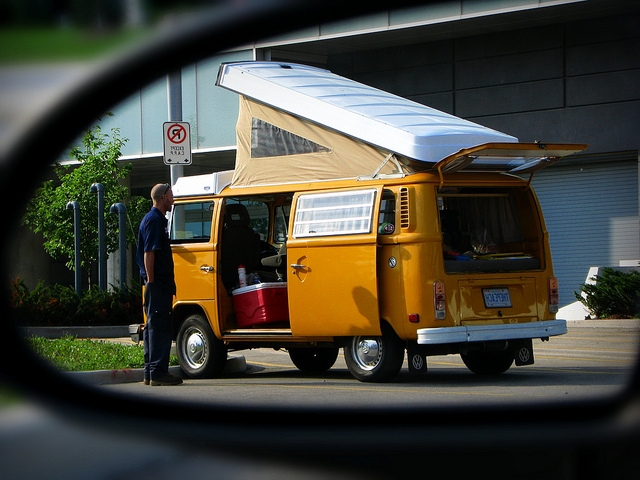

In [ ]:
image

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[-1]["image"]
instruction = "คิดแคปชั่นรูปนี้ให้หน่อย"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 0.5, min_p = 0.1)

ในภาพนี้มีเด็กชายหนุ่มๆ กำลังดื่มเครื่องดื่มในแก้วพลาสติกสีขาว ที่มีชิ้นขนมปังทอดและขนมปังปิ้งวางอยู่บนโต๊ะหน้าเด็ก ด้านหลังมีโต๊ะและเก้าอี้ที่มีคนสองคนกำลังนั่งดื่มเครื่องดื่มและทำงานบนคอมพิวเตอร์ ด้านหลังมีตู้วางของที่มีของหวานและเครื่องดื่มต่างๆ<|im_end|>


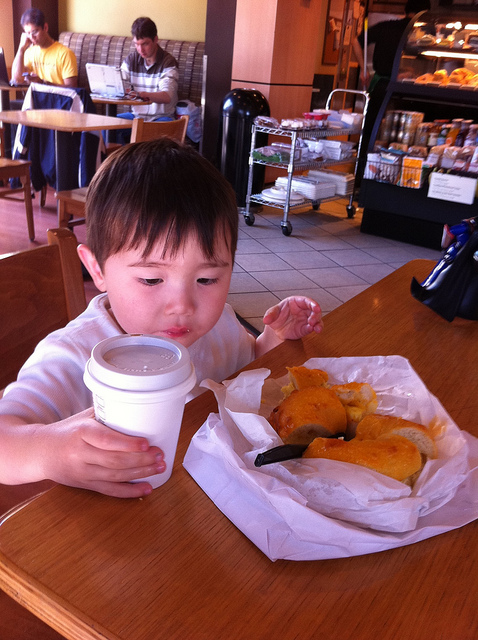

In [ ]:
image

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]